# Recommendation Systems Assignment

PMF: N is total number of users. 2 embeddings: user and item. D is the total number of latent variable. # of latent variable is same for user and item. select user embedding, select item embedding then take dot product. that will be the prediction of user_1 for item_6



### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #tuple is user, item, rating.
            if rating == 0:
                #only zero because this item hasn't been rated before.
                # only predicting the non-rated movies i.e. ones with 0
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]
                
                # Extract the items the user already rated
                #non-zero returns all non-zero items
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item. Item avg is zero if user hasn't rated anything
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
         # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))       

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:37, 1025.54it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:30, 1108.81it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
#look other similartiy matrix online for somethingelse
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 - pairwise_distances(matrix, metric='euclidean')
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1 - pairwise_distances(matrix, metric='manhattan')
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        #train_matrix is of user-item matrix form. Great.
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.ones(train_matrix.shape)
            # temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            # if k is not None:
            #     uu_similarity = kNearestNeighbor(uu_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
           
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            # normalizer[np.isnan(normalizer)] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, train_matrix)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)


            self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            #transpose the matrix to form item-user then run the whole code
            train_matrix = train_matrix.transpose()

            temp_matrix = np.ones(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            # if k is not None:
            #     ii_similarity = kNearestNeighbor(ii_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            # normalizer[np.isnan(normalizer)] = 1e-5
            #what's the dimension of np.matmul(ii_similarity, train_matrix)
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            #Remember predictionMatrix is of form item-user. Transpose it back to user-item matrix
            predictionMatrix = predictionMatrix.transpose()

            self.__model = predictionMatrix
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[ 1.        , -0.41421356, -0.41421356],
       [-0.41421356,  1.        , -0.41421356],
       [-0.41421356, -0.41421356,  1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[ 1., -1., -1.],
       [-1.,  1., -1.],
       [-1., -1.,  1.]])

(a) Which metric is better and why?

Cosine is better than euclidean because it is not sensitive to differences in length of each vector (like euclidean).

(b) If you want to put less emphasis on outliers, manhattan distance will try to reduce all errors equally since the gradient has constant magnitude (compared to euclidean). 

## Q3

### (a)

In [0]:
type(rating_df)

pandas.core.frame.DataFrame

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[2.42492083e+00, 7.58241451e-01, 4.44433098e-01, ...,
        5.37552717e-04, 6.51021154e-03, 7.36117851e-03],
       [1.88253580e+00, 3.25506086e-01, 3.02482424e-01, ...,
        3.36814306e-03, 2.77008816e-03, 1.91219324e-03],
       [1.32849217e+00, 2.90918284e-01, 2.36176026e-01, ...,
        8.35623444e-03, 2.61921448e-03, 1.18219930e-03],
       ...,
       [2.45321901e+00, 4.48412395e-01, 3.96938958e-01, ...,
        1.22401650e-03, 4.00566986e-03, 3.02918177e-03],
       [2.03994198e+00, 5.87603968e-01, 3.03290502e-01, ...,
        2.08310984e-03, 5.33460874e-03, 3.31510554e-03],
       [2.51325405e+00, 8.82071088e-01, 4.83121150e-01, ...,
        0.00000000e+00, 7.53072560e-03, 7.06815298e-03]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:19, 1257.64it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,0.709761
1,186,302,3,891717742,1.417402
2,22,377,1,878887116,0.056231
3,244,51,2,880606923,0.542357
4,166,346,1,886397596,0.724836


### (b)

In [0]:

class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2110.50it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2132.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2117.98it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2141.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2106.16it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2114.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2120.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2120.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2130.51it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2156.68it/s]


Processing algorithm user-cosine


20000it [00:09, 2126.19it/s]
20000it [00:09, 2143.92it/s]
20000it [00:09, 2133.42it/s]
20000it [00:09, 2126.44it/s]
20000it [00:09, 2128.28it/s]


{'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.343796394485685,
   0.4731707317073189,
   0.5741251325556754,
   0.610816542948039,
   0.5987274655355266],
  0.520127253446449,
  0.3804527491709955,
  0.6598017577219024],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
cv_patk_rmse = CrossValidation('RMSE')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:09, 2064.53it/s]
20000it [00:09, 2123.70it/s]
20000it [00:09, 2101.80it/s]
20000it [00:09, 2110.33it/s]
20000it [00:09, 2123.47it/s]


Processing algorithm item-cosine


20000it [00:09, 2091.21it/s]
20000it [00:09, 2115.52it/s]
20000it [00:09, 2089.16it/s]
20000it [00:09, 2111.16it/s]
20000it [00:09, 2120.15it/s]


{'item-cosine': [[3.276417382384763,
   3.1953347348835375,
   3.173209084219804,
   3.1917283968229344,
   3.241659435281614],
  3.215669806718531,
  3.163154068819332,
  3.2681855446177304],
 'user-cosine': [[3.0028491628944534,
   3.016487633769837,
   2.981130872479411,
   2.967941568079464,
   2.971307444833773],
  2.987943336411388,
  2.9618965382423235,
  3.0139901345804527]}

(b) We see that User-User cosine is better. This is because it is less dependent on the different preferences/tastes of each user. Even though there may be more ratings per item, each rating has a larger person to person error.

## Q4

### (a)

In [0]:
# a = pd.DataFrame({'UserID': [200,325,500], 'ItemID': [14,85,28],  'Rating': [6,7,8]})
# user = [200, 500]
# item = [14, 28]




# rating = []
# for index in range(0,len(user)):
#     trainSet_df_1 = pd.DataFrame()
#     trainSet_df_1 = a[(a["UserID"] == user[index]) & (a["ItemID"] == item[index])]
#     rating.append(trainSet_df_1.iloc[0]['Rating'])

# x = np.array(rating)
# x.shape

# given_val_df = pd.DataFrame({'UserID': user, 'ItemID': item})
# new_df = pd.merge(a, given_val_df,  how='inner', on=['UserID','ItemID'])
# new_df
# # new_array = np.array(new_df)


In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat) # item M x D 
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')


                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ##########       
                                
                x = np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :])
                pred_out = x.sum(axis = 1)                
                            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########

                    x = np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :])
                    pred_out = x.sum(axis = 1)           
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########

                    x = np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :])
                    pred_out = x.sum(axis = 1) 
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))
      

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

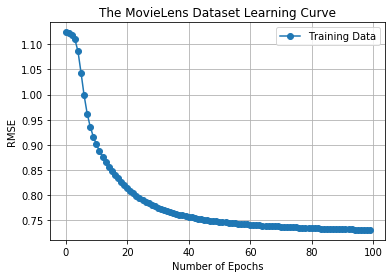

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')
popularity_recsys = BaseLineRecSys('popularity') 

user_cosine_recsys = SimBasedRecSys('user','cosine')
item_cosine_recsys = SimBasedRecSys('item','cosine')

pmf_recsys = PMFRecSys()


In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [average_user_rating_recsys, popularity_recsys,  user_cosine_recsys, item_cosine_recsys, pmf_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
cv_patk_rmse = CrossValidation('RMSE')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2100.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2122.29it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2136.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2147.24it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2131.13it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2132.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2128.25it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2150.97it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2136.00it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2151.72it/s]


Processing algorithm user-cosine


20000it [00:09, 2104.07it/s]
20000it [00:09, 2114.26it/s]
20000it [00:09, 2115.19it/s]
20000it [00:09, 2123.93it/s]
20000it [00:09, 2104.76it/s]


Processing algorithm item-cosine


20000it [00:09, 2122.64it/s]
20000it [00:09, 2113.90it/s]
20000it [00:09, 2047.09it/s]
20000it [00:09, 2113.19it/s]
20000it [00:09, 2133.19it/s]


Processing algorithm PMF


20000it [00:16, 1221.92it/s]
20000it [00:16, 1240.52it/s]
20000it [00:16, 1230.71it/s]
20000it [00:16, 1222.48it/s]
20000it [00:16, 1226.91it/s]


{'PMF': [[1.153485748210362,
   1.1295338201870346,
   1.111829090179362,
   1.1129967567440244,
   1.1183332676464208],
  1.125235736593441,
  1.1037859096936131,
  1.1466855634932687],
 'item-cosine': [[3.276417382384763,
   3.1953347348835375,
   3.173209084219804,
   3.1917283968229344,
   3.241659435281614],
  3.215669806718531,
  3.163154068819332,
  3.2681855446177304],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[3.0028491628944534,
   3.016487633769837,
   2.981130872479411,
   2.967941568079464,
   2.971307444833773],
  2.987943336411388,
  2.9618965382423235,
  3.0139901345804527],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [0]:
cv_patk_pk = CrossValidation('P@K')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk_pk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2094.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2140.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2111.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2108.48it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2080.47it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2116.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2146.77it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2120.86it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2115.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2110.86it/s]


Processing algorithm user-cosine


20000it [00:09, 2109.20it/s]
20000it [00:09, 2120.89it/s]
20000it [00:09, 2096.75it/s]
20000it [00:09, 2105.32it/s]
20000it [00:09, 2088.60it/s]


Processing algorithm item-cosine


20000it [00:09, 2126.31it/s]
20000it [00:09, 2133.45it/s]
20000it [00:09, 2119.81it/s]
20000it [00:09, 2149.82it/s]
20000it [00:09, 2132.26it/s]


Processing algorithm PMF


20000it [00:16, 1225.92it/s]
20000it [00:16, 1222.26it/s]
20000it [00:16, 1216.33it/s]
20000it [00:16, 1228.33it/s]
20000it [00:16, 1219.15it/s]


{'PMF': [[0.27317073170731715,
   0.4021208907741257,
   0.5028632025450699,
   0.5177094379639461,
   0.502226935312832],
  0.43961823966065816,
  0.31068706215651076,
  0.5685494171648056],
 'item-cosine': [[0.30371155885471945,
   0.4498409331919414,
   0.5488865323435856,
   0.570095440084837,
   0.5594909862142113],
  0.48640509013785893,
  0.34625177827605624,
  0.6265584019996616],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.343796394485685,
   0.4731707317073189,
   0.5741251325556754,
   0.610816542948039,
   0.5987274655355266],
  0.520127253446449,
  0.3804527491709955,
  0.6598017577219024],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [0]:
cv_patk_rk = CrossValidation('R@K')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk_rk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2140.67it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2139.06it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2093.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2100.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2144.29it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2155.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2137.55it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2120.41it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2108.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2121.52it/s]


Processing algorithm user-cosine


20000it [00:09, 2139.55it/s]
20000it [00:09, 2169.42it/s]
20000it [00:09, 2150.26it/s]
20000it [00:09, 2135.91it/s]
20000it [00:09, 2060.67it/s]


Processing algorithm item-cosine


20000it [00:09, 2115.93it/s]
20000it [00:09, 2123.22it/s]
20000it [00:09, 2105.74it/s]
20000it [00:09, 2176.77it/s]
20000it [00:09, 2082.80it/s]


Processing algorithm PMF


20000it [00:16, 1224.85it/s]
20000it [00:16, 1238.30it/s]
20000it [00:16, 1228.19it/s]
20000it [00:16, 1234.44it/s]
20000it [00:16, 1239.84it/s]


{'PMF': [[0.2801196577047488,
   0.36664837699409386,
   0.456554285154328,
   0.48113998896103044,
   0.495340029158201],
  0.4159604675944804,
  0.30304112635454206,
  0.5288798088344188],
 'item-cosine': [[0.286234208041766,
   0.3915345189390828,
   0.4867221295061973,
   0.5087180578746857,
   0.5166126601254376],
  0.4379643148974338,
  0.31575857009915026,
  0.5601700596957174],
 'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'user-cosine': [[0.3220724488566111,
   0.4156767702619418,
   0.49939395844719453,
   0.531528503469572,
   0.5416460065902704],
  0.462063537525118,
  0.34708124719908434,
  0.5770458278511517],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351]}

(b) Baseline useraverage cannot be evaluated using P@K and R@K because the results cannot be ranked.

(c) We see that PMF is the best. This is because it is a discriminative algorithm.  

(d) It is not necessary. RMSE is not dependent on ordering vs. other metrics are.

## Q6

a) I picked 4 Get Shorty, 5 CopyCat and 7 TwelveMonkeys

1) GetShorty: StandbyMe, StarTrek, So I married An Axe Murderer, Mighty Aphrodite, My own private Idaho]

2) CopyCat: Star Trek V: The Final Frontier (1989), Leaving Las Vegas (1995), Old Yeller (1957)', Ulee's Gold (1997), Mighty Aphrodite (1995)]

3) TwelveMonkeys: ['Star Trek V: The Final Frontier (1989)', 'Old Yeller (1957)', 'Leaving Las Vegas (1995)', 'Mighty Aphrodite (1995)', "Ulee's Gold (1997)"]


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
x = item_cosine_recsys.getModel()
y = x.transpose()

In [0]:
def userTopK(prediction, moviesDataset, userID, k):
    # Pick top K based on predicted rating
    userVector = prediction[userID+1,:]
    topK = nlargest(k, range(len(userVector)), userVector.take)
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK

In [0]:
userTopK(y, moviesDF, 4, 10)

['Stand by Me (1986)',
 'Star Trek V: The Final Frontier (1989)',
 'So I Married an Axe Murderer (1993)',
 'Mighty Aphrodite (1995)',
 'My Own Private Idaho (1991)',
 'Three Colors: Red (1994)',
 'Old Yeller (1957)',
 'FairyTale: A True Story (1997)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'True Crime (1995)']

In [0]:
userTopK(y, moviesDF, 5, 10)

['Star Trek V: The Final Frontier (1989)',
 'Leaving Las Vegas (1995)',
 'Old Yeller (1957)',
 "Ulee's Gold (1997)",
 'Mighty Aphrodite (1995)',
 'Three Colors: Red (1994)',
 'Twelve Monkeys (1995)',
 'Home Alone (1990)',
 'FairyTale: A True Story (1997)',
 'Stand by Me (1986)']

In [0]:
userTopK(y, moviesDF, 7, 10)

['Star Trek V: The Final Frontier (1989)',
 'Old Yeller (1957)',
 'Leaving Las Vegas (1995)',
 'Mighty Aphrodite (1995)',
 "Ulee's Gold (1997)",
 'Stand by Me (1986)',
 'Three Colors: Red (1994)',
 'Twelve Monkeys (1995)',
 'FairyTale: A True Story (1997)',
 'Home Alone (1990)']

(b) No we cannot justify because people have different preferences, hence the item-item similarities will vary person-person.

## Q7

(a) I picked threshold as 150 because <40 movies are rated. Yes, there are differences. The algorithm with more liked items performed better. This is because both algortihms rely on a person's rating to recommend movies. The more rich the data, the better the performance in RMSE metric.

(array([331., 156.,  73.,  73.,  55.,  55.,  37.,  30.,  29.,  17.,  23.,
         15.,  12.,   5.,   8.,   9.,   3.,   3.,   0.,   4.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([ 20. ,  43.9,  67.8,  91.7, 115.6, 139.5, 163.4, 187.3, 211.2,
        235.1, 259. , 282.9, 306.8, 330.7, 354.6, 378.5, 402.4, 426.3,
        450.2, 474.1, 498. , 521.9, 545.8, 569.7, 593.6, 617.5, 641.4,
        665.3, 689.2, 713.1, 737. ]),
 <a list of 30 Patch objects>)

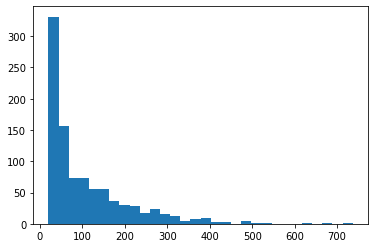

In [0]:
import scipy

trainUserItemMatrix = dataPreprocessor(rating_df, num_users, num_items)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.count_nonzero(trainUserItemMatrix, axis=1)

# x = np.random.normal(size = 1000)
plt.hist(x, bins=30)

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)